## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import copy

import pandas as pd

import numpy as np
import torch

from sklearn.metrics import roc_auc_score

from owkin.training import train, RocLoss
from owkin.dataset import build_dataset
from owkin.models.mono_models import MLP
from owkin.models.aggregators import SmoothMaxAggregator, MaxAggregator

import os
os.environ["WANDB_SILENT"] = "true"

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Get the Data

In [4]:
X_train, X_train_mean, y_train, X_val, X_val_mean, y_val, X_test_mean, X_test, df_test = build_dataset()

## Training

In [5]:
num_layers = 2
inside_dim = 512
mono_model = MLP(num_layers=num_layers, inside_dim=inside_dim)
pass

In [17]:
lr=1e-6
weight_decay = 1e-1
batch_size = 64
nb_epochs = 5000

In [38]:
list_train_loss, list_train_roc_auc_score, list_val_roc_auc_score = train(X_train_mean,
                                                                            y_train,
                                                                            X_val_mean,
                                                                            y_val,
                                                                            mono_model,
                                                                            learning_rate=lr,
                                                                            weight_decay=weight_decay,
                                                                            batch_size=batch_size,
                                                                            nb_epochs=nb_epochs,
                                                                            use_wandb=False,
                                                                            device=device)

epoch 1: loss=0.689, train_roc_auc_score=0.523, val_auc_roc_auc_score=0.427
epoch 500: loss=0.687, train_roc_auc_score=0.489, val_auc_roc_auc_score=0.466
epoch 1000: loss=0.686, train_roc_auc_score=0.469, val_auc_roc_auc_score=0.515
epoch 1500: loss=0.685, train_roc_auc_score=0.483, val_auc_roc_auc_score=0.545
epoch 2000: loss=0.684, train_roc_auc_score=0.471, val_auc_roc_auc_score=0.637
epoch 2500: loss=0.684, train_roc_auc_score=0.504, val_auc_roc_auc_score=0.566
epoch 3000: loss=0.683, train_roc_auc_score=0.499, val_auc_roc_auc_score=0.454
epoch 3500: loss=0.683, train_roc_auc_score=0.478, val_auc_roc_auc_score=0.554
epoch 4000: loss=0.683, train_roc_auc_score=0.500, val_auc_roc_auc_score=0.500


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


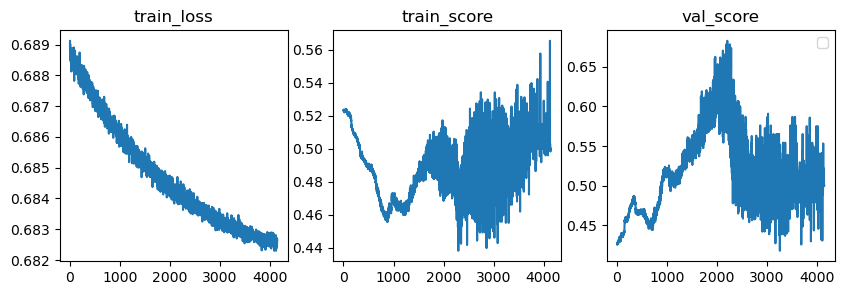

In [39]:
fig, ax = plt.subplots(1,3, figsize=(10,3))
ax[0].plot(list_train_loss)
ax[0].set_title("train_loss")
ax[1].plot(list_train_roc_auc_score)
ax[1].set_title("train_score")
ax[2].plot(list_val_roc_auc_score)
ax[2].set_title("val_score")
plt.legend()

In [13]:
mono_model.best_path = Path("saved_models/MLP/num_layers_10_inside_dim_512/best_epoch_2206_score_0.683.pt")

In [16]:
print(f"best path: {mono_model.best_path}")

mono_model.load_state_dict(torch.load(mono_model.best_path))
mono_model.eval()

print(f"val score: {roc_auc_score(y_val, mono_model(torch.Tensor(X_val_mean).to(device)).cpu().detach())}")

best path: saved_models\MLP\num_layers_10_inside_dim_512\best_epoch_2206_score_0.683.pt
val score: 0.6828063241106719


In [19]:
num_layers = 2
inside_dim = 512
mono_model = MLP(num_layers=num_layers, inside_dim=inside_dim)
mono_model.to(device)
pass

In [20]:
if mono_model.best_path is None:
    best_val_score = 0
    best_path = None
    for model_path in Path(f"saved_models/{mono_model.name}").glob("*"):
        val_score = float(model_path.name[-8:-3])
        if val_score > best_val_score:
            best_path = model_path
            best_val_score = val_score
    mono_model.best_path = best_path
else:
    print("model got already a best path:")
    
print(f"best path: {mono_model.best_path}")

mono_model.load_state_dict(torch.load(mono_model.best_path))
mono_model.eval()

print(f"val score: {roc_auc_score(y_val, mono_model(torch.Tensor(X_val_mean).to(device)).cpu().detach())}")

best path: saved_models\MLP\num_layers_2_inside_dim_512\best_epoch_2095_score_0.750.pt
val score: 0.75


In [6]:
model = SmoothMaxAggregator(mono_model=mono_model)

In [23]:
lr=1e-5
weight_decay = 0
batch_size = 8
nb_epochs = 500

In [24]:
list_train_loss, list_train_roc_auc_score, list_val_roc_auc_score = train(X_train,
                                                                            y_train,
                                                                            X_val,
                                                                            y_val,
                                                                            model,
                                                                            learning_rate=lr,
                                                                            weight_decay=weight_decay,
                                                                            batch_size=batch_size,
                                                                            nb_epochs=nb_epochs,
                                                                            use_wandb=False,
                                                                            device=device)

epoch 1: loss=1.885, train_roc_auc_score=0.953, val_auc_roc_auc_score=0.735
epoch 50: loss=1.873, train_roc_auc_score=0.889, val_auc_roc_auc_score=0.793
epoch 100: loss=1.873, train_roc_auc_score=0.876, val_auc_roc_auc_score=0.786


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


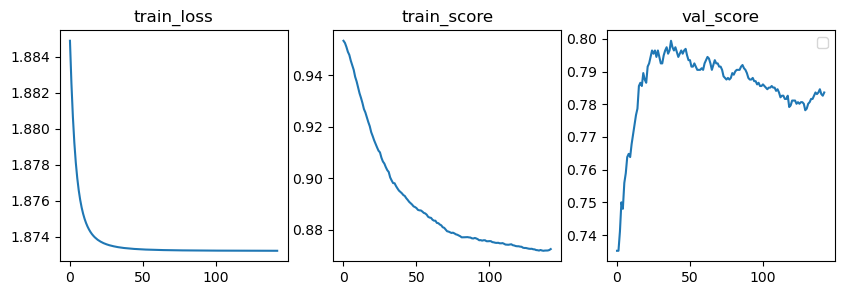

In [25]:
fig, ax = plt.subplots(1,3, figsize=(10,3))
ax[0].plot(list_train_loss)
ax[0].set_title("train_loss")
ax[1].plot(list_train_roc_auc_score)
ax[1].set_title("train_score")
ax[2].plot(list_val_roc_auc_score)
ax[2].set_title("val_score")
plt.legend()

In [26]:
model = SmoothMaxAggregator(mono_model=mono_model)

In [27]:
lr=1e-5
weight_decay = 1e-1
batch_size = 8
nb_epochs = 500

In [28]:
list_train_loss, list_train_roc_auc_score, list_val_roc_auc_score = train(X_train,
                                                                            y_train,
                                                                            X_val,
                                                                            y_val,
                                                                            model,
                                                                            learning_rate=lr,
                                                                            weight_decay=weight_decay,
                                                                            batch_size=batch_size,
                                                                            nb_epochs=nb_epochs,
                                                                            use_wandb=False,
                                                                            device=device)

epoch 1: loss=1.886, train_roc_auc_score=0.953, val_auc_roc_auc_score=0.731
epoch 50: loss=1.886, train_roc_auc_score=0.953, val_auc_roc_auc_score=0.732
epoch 100: loss=1.887, train_roc_auc_score=0.926, val_auc_roc_auc_score=0.727
epoch 150: loss=1.890, train_roc_auc_score=0.830, val_auc_roc_auc_score=0.710
epoch 200: loss=1.893, train_roc_auc_score=0.719, val_auc_roc_auc_score=0.695


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


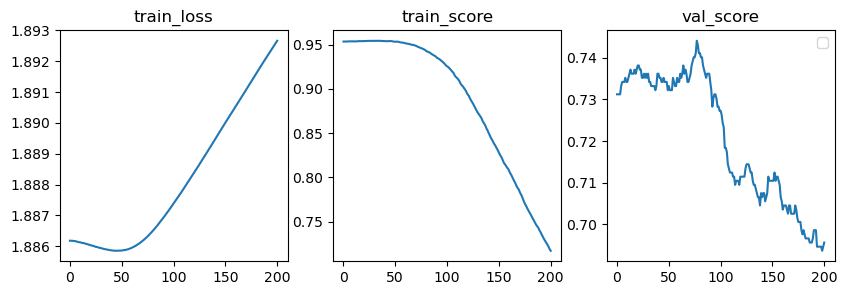

In [29]:
fig, ax = plt.subplots(1,3, figsize=(10,3))
ax[0].plot(list_train_loss)
ax[0].set_title("train_loss")
ax[1].plot(list_train_roc_auc_score)
ax[1].set_title("train_score")
ax[2].plot(list_val_roc_auc_score)
ax[2].set_title("val_score")
plt.legend()

In [38]:
model = SmoothMaxAggregator(mono_model=mono_model)

In [39]:
lr=1e-5
weight_decay = 1e-2
batch_size = 8
nb_epochs = 500

In [40]:
list_train_loss, list_train_roc_auc_score, list_val_roc_auc_score = train(X_train,
                                                                            y_train,
                                                                            X_val,
                                                                            y_val,
                                                                            model,
                                                                            learning_rate=lr,
                                                                            weight_decay=weight_decay,
                                                                            batch_size=batch_size,
                                                                            nb_epochs=nb_epochs,
                                                                            use_wandb=False,
                                                                            device=device)

epoch 1: loss=1.886, train_roc_auc_score=0.953, val_auc_roc_auc_score=0.734
epoch 50: loss=1.878, train_roc_auc_score=0.938, val_auc_roc_auc_score=0.748
epoch 100: loss=1.877, train_roc_auc_score=0.859, val_auc_roc_auc_score=0.740


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


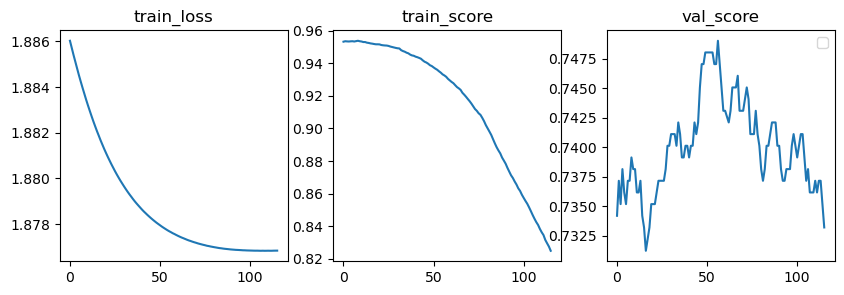

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,3))
ax[0].plot(list_train_loss)
ax[0].set_title("train_loss")
ax[1].plot(list_train_roc_auc_score)
ax[1].set_title("train_score")
ax[2].plot(list_val_roc_auc_score)
ax[2].set_title("val_score")
plt.legend()

In [34]:
model = SmoothMaxAggregator(mono_model=mono_model)

In [35]:
lr=1e-5
weight_decay = 1e-3
batch_size = 8
nb_epochs = 500

In [36]:
list_train_loss, list_train_roc_auc_score, list_val_roc_auc_score = train(X_train,
                                                                            y_train,
                                                                            X_val,
                                                                            y_val,
                                                                            model,
                                                                            learning_rate=lr,
                                                                            weight_decay=weight_decay,
                                                                            batch_size=batch_size,
                                                                            nb_epochs=nb_epochs,
                                                                            use_wandb=False,
                                                                            device=device)

epoch 1: loss=1.885, train_roc_auc_score=0.953, val_auc_roc_auc_score=0.735
epoch 50: loss=1.874, train_roc_auc_score=0.921, val_auc_roc_auc_score=0.747
epoch 100: loss=1.874, train_roc_auc_score=0.850, val_auc_roc_auc_score=0.756
epoch 150: loss=1.874, train_roc_auc_score=0.726, val_auc_roc_auc_score=0.715


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


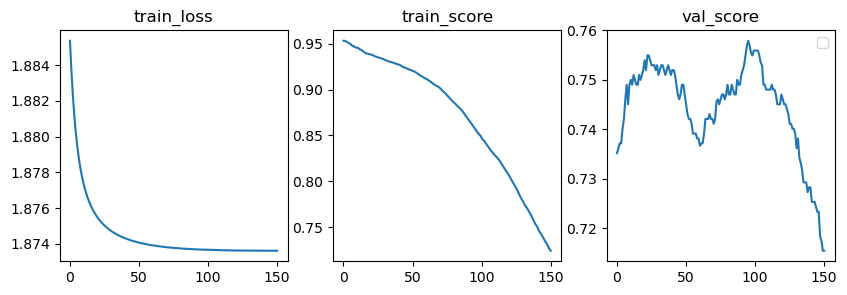

In [37]:
fig, ax = plt.subplots(1,3, figsize=(10,3))
ax[0].plot(list_train_loss)
ax[0].set_title("train_loss")
ax[1].plot(list_train_roc_auc_score)
ax[1].set_title("train_score")
ax[2].plot(list_val_roc_auc_score)
ax[2].set_title("val_score")
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


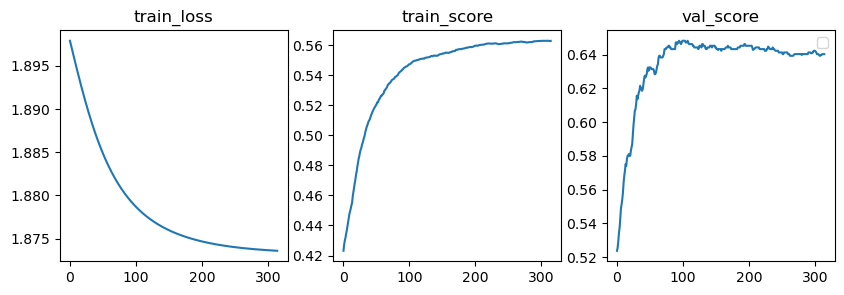

In [35]:
fig, ax = plt.subplots(1,3, figsize=(10,3))
ax[0].plot(list_train_loss)
ax[0].set_title("train_loss")
ax[1].plot(list_train_roc_auc_score)
ax[1].set_title("train_score")
ax[2].plot(list_val_roc_auc_score)
ax[2].set_title("val_score")
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


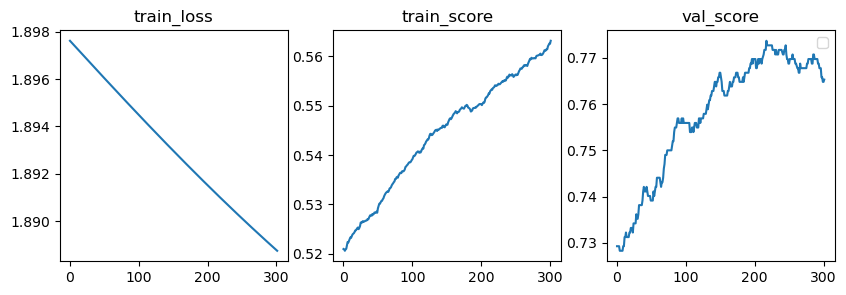

In [31]:
fig, ax = plt.subplots(1,3, figsize=(10,3))
ax[0].plot(list_train_loss)
ax[0].set_title("train_loss")
ax[1].plot(list_train_roc_auc_score)
ax[1].set_title("train_score")
ax[2].plot(list_val_roc_auc_score)
ax[2].set_title("val_score")
plt.legend()

In [ ]:
model.name

In [10]:
if model.best_path is None:
    best_val_score = 0
    best_path = None
    for model_path in Path(f"saved_models/{model.name}").glob("*"):
        val_score = float(model_path.name[-8:-3])
        if val_score > best_val_score:
            best_path = model_path
            best_val_score = val_score
    model.best_path = best_path
else:
    print("model got already a best path:")
    
print(f"best path: {model.best_path}")

model.load_state_dict(torch.load(model.best_path))
model.eval()

print(f"val score: {roc_auc_score(y_val, model(torch.Tensor(X_val)).cpu().detach())}")

model got already a best path:
best path: saved_models\SmoothMaxAggregator\MLP\num_layers_2_inside_dim_512\best_epoch_331_score_0.809.pt
val score: 0.808300395256917


## Analysis

In [39]:
# trainings finished, we put all on cpu
model.cpu()
model.eval()

max_model.cpu()
max_model.eval()

smooth_max_model.cpu()
smooth_max_model.eval()
pass

NameError: name 'max_model' is not defined

In [ ]:
val_predictions = model(torch.Tensor(X_val)).detach().cpu()

val_max_preditions = max_model(torch.Tensor(X_val_all)).detach().cpu()

val_smooth_max_preditions = smooth_max_model(torch.Tensor(X_val_all)).detach().cpu()

### ROC Curve

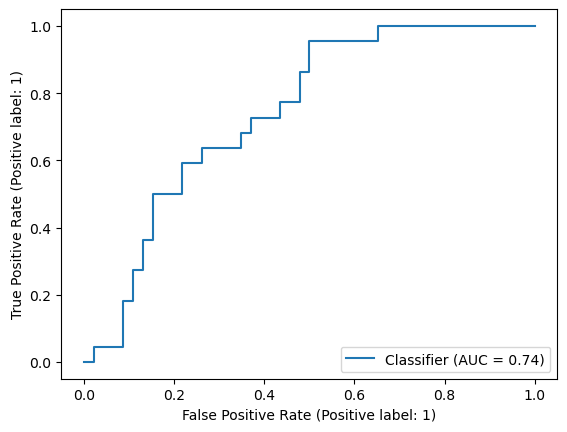

In [ ]:
# Predictions of model
RocCurveDisplay.from_predictions(y_val, val_predictions)

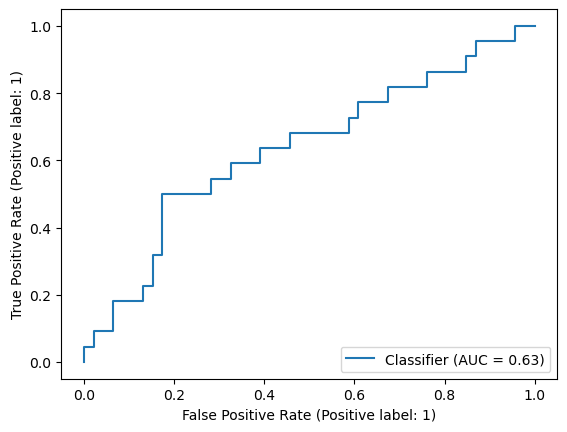

In [ ]:
# Predictions of max model
RocCurveDisplay.from_predictions(y_val, val_max_preditions)

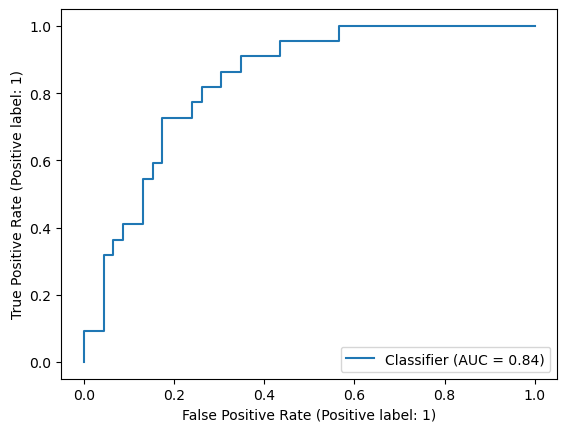

In [ ]:
# Predictions of smooth max model
RocCurveDisplay.from_predictions(y_val, val_smooth_max_preditions)

## Repartitions

In [ ]:
X_positive_train = X_train_all[y_train == 1]
X_negative_train = X_train_all[y_train == 0]

In [ ]:
all_positive_features = torch.Tensor(X_positive_train)
all_negative_features = torch.Tensor(X_negative_train)

all_positive_predict = max_model(all_positive_features).flatten()
all_negative_predict = max_model(all_negative_features).flatten()

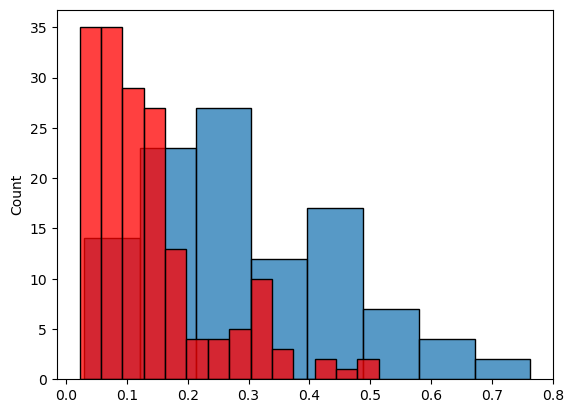

In [ ]:
sns.histplot(all_positive_predict.detach(), label="positive")
sns.histplot(all_negative_predict.detach(), label="negative", color="r")
plt.legend()
plt.show()

In [ ]:
raise ValueError

ValueError: 

## Inference for submission

In [11]:
model_val_score = roc_auc_score(y_val, model(torch.Tensor(X_val)).cpu().detach())
print(model_val_score)

0.808300395256917


In [12]:
y_test = model(torch.Tensor(X_test)).cpu().detach().squeeze().numpy()

In [15]:
submission = pd.DataFrame(
    {"Sample ID": df_test["Sample ID"].values, "Target": y_test}
).sort_values(
    "Sample ID"
)  # extra step to sort the sample IDs

# sanity checks
assert all(submission["Target"].between(0, 1)), "`Target` values must be in [0, 1]"
assert submission.shape == (149, 2), "Your submission file must be of shape (149, 2)"
assert list(submission.columns) == [
    "Sample ID",
    "Target",
], "Your submission file must have columns `Sample ID` and `Target`"

# save the submission as a csv file

PATH_DIR = Path(f"data/test_outputs/{model.type}")
if not PATH_DIR.is_dir():
    os.makedirs(PATH_DIR)
submission.to_csv(f"data/test_outputs/{model.name}_{'{:.4f}'.format(model_val_score)}.csv", index=None)
submission.head()

,Sample ID,Target
0,ID_003.npy,0.007907
1,ID_004.npy,0.007908
2,ID_008.npy,0.007907
3,ID_009.npy,0.007905
4,ID_010.npy,0.007907
